In [2]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import math 

In [3]:
!ls

7jsk.cif                         model_o134_data.txt
Stability_analysis_slc13a5.ipynb model_o134_mean.txt
changedResidues_IF_OF.txt        model_o134_mean_std_cis.txt
evolConservation.mapped          model_o1_foldx.txt
evolConservation_mapped.txt      model_o3_foldx.txt
model_i123_data.txt              model_o4_foldx.txt
model_i123_mean.txt              notes.txt
model_i123_mean_std_cis.txt      result_deltaStability.txt
model_i1_foldx.txt               script_pymol.pml
model_i2_foldx.txt               slc13a5_BC_foldx.txt
model_i3_foldx.txt               slc13a5_B_foldx.txt
model_i5_foldx.txt


In [4]:
def readFoldXresult ( file ):
    '''
    '''
    with open( file, 'r') as f:
        o = f.read()
        f.close()
    t = o.split('\n')

    m = {}
    s = {}
    for i in range(len(t)):
        if t[i]:
            m[t[i].split()[0]+t[i].split()[1]+t[i].split()[2]] = float(t[i].split()[3])
            s[t[i].split()[0]+t[i].split()[1]+t[i].split()[2]] = float(t[i].split()[4])
    return m,s

In [91]:
def readDMSscores ( file ):
    '''
S	332	I	0.555245	0.250267
S	332	M	-0.138821	0.376385
R	333	Q	0.378759	0.397804
R	333	H	-0.804945	0.112140
    '''
    with open( file, 'r') as f:
        o = f.read()
        f.close()
    t = o.split('\n')

    score = {}
    std = {}
    for i in range(len(t)):
        if t[i]:
            score[t[i].split()[1]+t[i].split()[0]+t[i].split()[2]] = float(t[i].split()[3])
            std[t[i].split()[1]+t[i].split()[0]+t[i].split()[2]] = float(t[i].split()[4])
    return score,std

In [133]:
def readResList ( file ):
    '''

    '''
    with open( file, 'r') as f:
        o = f.read()
        f.close()
    t = o.split('\n')

    lres = []
    for i in range(len(t)):
        if t[i]:
            lres.append(t[i]) 
    return lres

In [5]:
def averageDicts ( d1, d2, d3):
    '''
    '''
    common_keys = d1.keys() & d2.keys() & d3.keys()

    m = {}
    s = {}
    c1 = {}
    c2 = {}
    for k in common_keys:
        m[k] = stat.mean([d1[k], d2[k], d3[k]])
        s[k] = stat.stdev([d1[k], d2[k], d3[k]])
        c1[k] = m[k]-1.96*s[k]/math.sqrt(3)
        c2[k] = m[k]+1.96*s[k]/math.sqrt(3)
    return m,s,c1,c2

In [6]:
def filterDictsByStdev ( m1, s1, m2, s2, threshold ):
    '''
    '''
    ma = m1.copy()
    sa = s1.copy()
    mb = m2.copy()
    sb = s2.copy()
    t = threshold
    for i,j in m1.items():
        if s1[i] > t or s2[i]>t:
            del ma[i]
            del sa[i]
            del mb[i]
            del sb[i]
    return ma, sa, mb, sb

In [7]:
def filterDictsByConfidence ( m1, s1, m2, s2, threshold ):
    '''
    '''
    ma = m1.copy()
    sa = s1.copy()
    mb = m2.copy()
    sb = s2.copy()
    rio = {}
    t = threshold
    for i,j in m1.items():
        up = m1[i]+2*t
        down = m1[i]-2*t
        if (m2[i]>up and m1[i]>(-2*t) and m1[i]<2*t):
            rio[i] = 'out' 
            pass
        elif (m2[i]<down and m2[i]>(-2*t) and m2[i]<2*t):
            rio[i] = 'in'
            pass
        else:
            del ma[i]
            del sa[i]
            del mb[i]
            del sb[i]
    return ma, sa, mb, sb, rio

In [8]:
def writeResidues ( mi, si, mo, so, rio, ofile ):
    '''
    '''
    with open(ofile, 'w') as f:
        for i,j in mi.items():
            if i in mo:
                wtaa = ''.join(list(i)[-2:-1])
                site = ''.join(list(i)[:-2])
                mutaa = ''.join(list(i)[-1:])
                uci_i = mi[i]+1.96*si[i]/math.sqrt(3) 
                lci_i = mi[i]-1.96*si[i]/math.sqrt(3) 
                uci_o = mo[i]+1.96*so[i]/math.sqrt(3)
                lci_o = mo[i]-1.96*so[i]/math.sqrt(3)
                f.write('%s\t%s\t%s\t%s\t%lf\t%lf\t%lf\t%lf\t%lf\t%lf\n' % (rio[i], wtaa, site, mutaa, mi[i], uci_i, lci_i, mo[i], uci_o, lci_o))
    f.close()
    

In [9]:
def correlateStability ( mi, si, mo, so, t, min_, max_, xlab, ylab):
    '''
    '''
    
    mi, si, mo, so = filterDictsByStdev ( mi, si, mo, so, t )

    imean = dict((k, mi[k]) for k in list(mi.keys() & mo.keys() ))
    omean = dict((k, mo[k]) for k in list(mi.keys() & mo.keys() ))

    x0 = list(imean.values())
    y0 = list(omean.values())

    corr_matrix = np.corrcoef(x0, y0)
    corr = corr_matrix[0,1]
    R_sq0 = corr**2
    
    px = 1/plt.rcParams['figure.dpi']
    fig, axs = plt.subplots(1, 1, figsize=(500*px, 500*px))
    axs.scatter(x0, y0, c ="gray", s=4) 
    #axs.set_title('Input lib') 
    axs.annotate("R^2 = {:.3f}".format(R_sq0), (min_+0.5 , max_ - 1.0))
    #m, b = np.polyfit(np.array(x0), np.array(y0), 1)
    #axs.plot(x0, m*np.array(x0)+b, color='black')
    #min_ = min(min(x0),min(y0))
    #max_ = max(max(x0),max(y0))
    axs.set_xlim(min_,max_)
    axs.set_ylim(min_,max_)

    axs.grid(True, which="both")
    axs.plot([min_, max_], [min_, max_], ls="-", color='black')
    axs.plot([0, 0], [min_, max_], ls="-", color='black' ) #c=".3")
    axs.plot([min_, max_], [0.0, 0.0], ls="-", color='black' ) #c=".3")
    axs.plot([min_, max_], [min_+2*t, max_+2*t], ls="--", c=".3")
    axs.plot([min_, max_], [min_-2*t, max_-2*t], ls="--", c=".3")
    
    axs.plot([-2*t, -2*t], [min_, max_], ls="--", c=".3")
    axs.plot([2*t, 2*t], [min_, max_], ls="--", c=".3")
    axs.plot([min_, max_], [2*t, 2*t], ls="--", c=".3")
    axs.plot([min_, max_], [-2*t, -2*t], ls="--", c=".3")
#    for ax in axs.flat:
    axs.set(xlabel=xlab, ylabel=ylab)

# highlight plot
    mi, si, mo, so, r = filterDictsByConfidence ( mi, si, mo, so, t )
    writeResidues ( mi, si, mo, so, r, 'results_deltaStability.txt' )

    imean = dict((k, mi[k]) for k in list(mi.keys() & mo.keys() ))
    omean = dict((k, mo[k]) for k in list(mi.keys() & mo.keys() ))
    
    x0 = list(imean.values())
    y0 = list(omean.values())
    
    axs.scatter(x0, y0, c ="red", s=4) 
    plt.show()

### Reading FoldX results

In [10]:
i1,si1 = readFoldXresult('model_i1_foldx.txt')
i3,si3 = readFoldXresult('model_i3_foldx.txt')
i5,si5 = readFoldXresult('model_i5_foldx.txt')

o1,so1 = readFoldXresult ('model_o1_foldx.txt')
o3,so3 = readFoldXresult ('model_o3_foldx.txt')
o4,so4 = readFoldXresult ('model_o4_foldx.txt')

### Filtering and plotting

In [11]:
mi,si,c1i,c2i = averageDicts ( i1,i3,i5 )
mo,so,c1o,c2o = averageDicts ( o1,o3,o4 )

correlateStability (mi, si, mo, so, 0.5, -5, 15, '$\Delta$Stability IF conformer ($\Delta\Delta$G, kcal/mol)', '$\Delta$Stability OF conformer ($\Delta\Delta$G, kcal/mol)')
!mv results_deltaStability.txt changedResidues_IF_OF.txt 


### Differences between monomer and dimer

In [12]:
mono_m, mono_s = readFoldXresult('slc13a5_B_foldx.txt')
di_m, di_s = readFoldXresult('slc13a5_BC_foldx.txt')


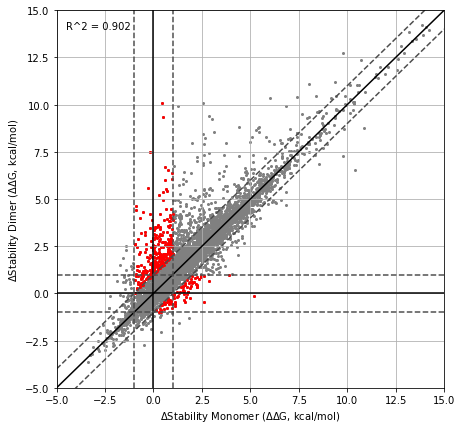

In [13]:
correlateStability (mono_m, mono_s, di_m, di_s, 0.5, -5, 15, '$\Delta$Stability Monomer ($\Delta\Delta$G, kcal/mol)', '$\Delta$Stability Dimer ($\Delta\Delta$G, kcal/mol)')
!mv results_deltaStability.txt changedResidues_IF_OF.txt

### DMS scores

In [14]:
def readAverageScores ( ifile ) :
    '''
    '''
    with open ( ifile, 'r') as f:
        o = f.read()
        f.close()
    t = o.split('\n')

    s ={}
    e ={}
    for i in range(len(t)):
        if '\t' in t[i]:
            r = t[i].split('\t')
            if 'p.' in r[0] and 'p.=' not in r[0]:
                s[r[0].split('p.')[1].split(')')[0]] = float(r[3])
                e[r[0].split('p.')[1].split(')')[0]] = float(r[1])
    return s, e 

In [15]:
!pwd

/Users/eferrada/Dropbox/Chile2024/Projects/SLC13A5/STABILITY


In [16]:
from pylab import *
from scipy.optimize import curve_fit

scores = './ENRICH/counts/tsv/13A5_joined_exp/main_variants_scores.tsv'    
s1, e1 = readAverageScores ( scores )

data = list(s1.values())
for i in range(len(data)):
    data[i] = data[i]*(-1.0)
    
y,x,_=hist(data,50,alpha=.7,label='data', color = "skyblue", edgecolor='black',lw=1, range=[-2,1.5], density=True)
plt.xlabel('Regression slope')
plt.ylabel('Density')
plt.grid()

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(-1.0,0.2,0.8,0.0,.2,0.8)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))
plot(x,bimodal(x,*params),color='red',lw=1,label='model')

legend()
print("mu_1, std_1, lambda_1: ",params[0:3],'\n',sigma[0:3]) 
print("mu_2, std_2, lambda_2: ",params[3:6],'\n',sigma[3:6]) 

mu_1, std_1, lambda_1:  [-0.98971355  0.2264625   0.64957945] 
 [0.00519495 0.00541805 0.01222445]
mu_2, std_2, lambda_2:  [0.00303588 0.28445819 0.88134902] 
 [0.00425113 0.0045486  0.01102143]


In [17]:
## saving scores and error
with open('13a5_scores.txt', 'a') as f:
    for i,j in s1.items():
        if i in e1:
            f.write('%s\t%lf\t%lf\n' % (i, (-1)*j, e1[i]))
    f.close()

### Pymol

In [19]:
def plotDeltaStabilityPymol ( mi, si, mo, so, t, q):
    '''
    '''
    mi, si, mo, so = filterDictsByStdev ( mi, si, mo, so, t )
    mi, si, mo, so, rio = filterDictsByConfidence ( mi, si, mo, so, t )
    #writeResidues ( mi, si, mo, so, r, 'results_deltaStability.txt' )
    
    val = []
    for i,j in mi.items():
        #if rio[i] == 'in':
        val.append(abs(float(mi[i])-float(mo[i])))
        #else:
        #    valout.append(abs(float(mi[i])-float(mo[i])))
            
    sel = max(val)-q*(max(val)-min(val))
    #sel_down = min(val)+q*(max(val)-min(val))
    
    #selo_up = max(valout)-q*(max(valout)-min(valout))/100
    #selo_down = min(valout)+q*(max(valout)-min(valout))/100

    inres=[]
    outres=[]
    ivar = []
    ovar = []
    for i,j in mi.items():
        if i in mo:
            wtaa = ''.join(list(i)[-2:-1])
            diff = float(abs(mi[i]-mo[i]))
            if diff > sel:
                if rio[i] == 'in':
                    #if diffmi[i]>seli_up or mi[i]<seli_down:
                    inres.append(str(''.join(list(i)[:-2])))
                    ivar.append(str(i))
                else:
                    #if mo[i]>selo_up or mo[i]<selo_down:
                    outres.append(str(''.join(list(i)[:-2])))
                    ovar.append(str(i))
            mutaa = ''.join(list(i)[-1:])
            #uci_i = mi[i]+1.96*si[i]/math.sqrt(3) 
            #lci_i = mi[i]-1.96*si[i]/math.sqrt(3) 
            #uci_o = mo[i]+1.96*so[i]/math.sqrt(3)
            #lci_o = mo[i]-1.96*so[i]/math.sqrt(3)

    pin = '+'.join(inres)
    pout = '+'.join(outres)
    print(pin)
    print(pout)

    with open('script_pymol.pml', 'w') as f:
        f.write('fetch 7jsk\n')
        f.write('set cartoon_cylindrical_helices, 1\n')
        f.write('as cartoon\n')
        f.write('bg_color grey')
        f.write('sel ca, chain A\n')
        f.write('sel cb, chain B\n')
        f.write('color cyan, cb\n')
        # inward changed residues
        f.write('sel pin, resi %s\n' %  pin )
        f.write('color yellow, pin\n')
        f.write('show spheres, pin\n')
        # outward changed residues
        f.write('sel pout, resi %s\n' %  pout )
        f.write('color red, pout\n')
        f.write('show spheres, pout\n')

        f.write('hide licorice\n')
        f.close()
    os.system('pymol script_pymol.pml')
    return ivar, inres, ovar, outres

In [149]:
def compromisedResidues ( lres ):
    '''
    '''
    import re
    import collections
    h = {}
    s = {}
    m = {}
    for i in range(len(lres)):
        j = int(re.sub('\D','', str(lres[i])))
        if j > 568:
            j = j-568
        wtaa = list(lres[i])[-2]
        if j in h:
            h[j]+=1
            m[j].append(str(list(lres[i])[-1]))
        else:
            h[j]=1   
            s[j]=wtaa
            m[j]=[]
            m[j].append(str(list(lres[i])[-1]))

    o = collections.OrderedDict(sorted(h.items()))
    for i,j in o.items():
        print('%s\t%s --> (%d) %s' % (str(i),s[i],int(j), ''.join(m[i])))

In [132]:
def compromisedResiduesStandard ( lres ):
    '''
    '''
    import re
    h = {}
    s = {}
    m = {}
    for i in range(len(lres)):
        j = int(re.sub('\D','', str(lres[i])))
        if j > 568:
            j = j-568
        wtaa = list(lres[i])[0]
        if j in h:
            h[j]+=1
            m[j].append(str(list(lres[i])[-1]))
        else:
            h[j]=1   
            s[j]=wtaa
            m[j]=[]
            m[j].append(str(list(lres[i])[-1]))

    for i,j in h.items():
        print('%s\t%s --> (%d) %s' % (str(i),s[i],int(j), ''.join(m[i])))

In [129]:
mi,si,c1i,c2i = averageDicts ( i1,i3,i5 )
mo,so,c1o,c2o = averageDicts ( o1,o3,o4 )


In [130]:
ivar,inres, ovar,outres = plotDeltaStabilityPymol(mi, si, mo, so, 0.5, 0.92)


800+109+134+131+234+300+798+298+456+799+147+231+800+819+677+235+109+803+109+799+299+299+299+131+818
722+302+704+513+949+630+610+437+302+141+708+944+208+700+529+507+722+722+437+118+867+222
 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected OpenGL version 2.1. Shaders available.
 Detected GLSL vers

In [84]:
compromisedResidues(ivar)

232	V --> (2) YF
109	I --> (4) EEAD
134	L --> (1) S
131	V --> (2) DQ
234	L --> (1) V
300	K --> (1) P
230	N --> (1) G
298	A --> (1) T
456	V --> (1) R
231	V --> (3) TTD
147	M --> (1) L
251	A --> (1) T
235	G --> (2) AH
299	L --> (3) IDY
250	F --> (1) K


In [85]:
compromisedResidues(ovar) 

154	A --> (3) CNK
302	L --> (2) SG
136	S --> (1) N
513	I --> (1) E
381	S --> (1) N
62	M --> (1) F
42	I --> (1) T
437	M --> (2) RK
141	N --> (1) L
140	S --> (1) T
376	K --> (1) E
208	M --> (1) P
132	T --> (1) Y
529	G --> (1) I
507	A --> (1) V
118	G --> (1) A
299	L --> (1) F
222	A --> (1) R


### Validated variants

In [139]:
validated = readResList('validated_aa.txt')
compromisedResiduesStandard(validated)

2	A --> (1) T
39	A --> (1) T
72	I --> (1) T
91	L --> (1) P
96	V --> (1) M
106	H --> (1) R
108	R --> (1) M
123	R --> (1) Q
145	T --> (2) KM
147	M --> (1) I
201	R --> (1) Q
215	A --> (1) V
217	S --> (1) N
219	G --> (1) R
222	A --> (1) S
251	A --> (1) V
311	P --> (1) S
315	A --> (1) T
342	L --> (1) P
346	W --> (1) L
359	V --> (1) M
363	V --> (1) L
402	T --> (1) I
407	P --> (1) R
423	G --> (1) E
427	S --> (1) L
431	V --> (1) M
444	P --> (1) S
458	V --> (1) M
465	N --> (1) H
471	L --> (1) S
474	P --> (1) L
481	R --> (1) H
492	L --> (1) P
499	S --> (1) F
533	N --> (1) K
558	P --> (1) L


### Residues stabilizing the dimer

In [142]:
mono_m, mono_s = readFoldXresult('slc13a5_B_foldx.txt')
di_m, di_s = readFoldXresult('slc13a5_BC_foldx.txt')

#mi,si,c1i,c2i = averageDicts ( i1,i3,i5 )
#mo,so,c1o,c2o = averageDicts ( o1,o3,o4 )

ivar,inres, ovar,outres = plotDeltaStabilityPymol(mono_m, mono_s, di_m, di_s, 0.1, 0.8)

69+126+163+163+201+285+395+411+422+542+542
10+10+57+58+65+65+76+76+76+76+76+79+93+149+163+273+279+333+333+346+346+353+358+358+365+369+369+369+369+379+379+379+379+407+407+407+407+407+407+407+426+478+478+513+515+545+545+545
 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected OpenGL version 2.1. Shad

In [66]:
compromisedResidues(ivar)

60	S --> (1) T
411	V --> (1) F
490	I --> (1) F


In [67]:
compromisedResidues (ovar)

10	K --> (5) DEFWY
57	A --> (4) NQRW
58	V --> (6) DEGHKS
64	V --> (2) EQ
65	L --> (2) DT
75	S --> (1) E
76	R --> (2) DN
77	Q --> (1) P
79	C --> (2) HK
88	M --> (1) E
93	G --> (1) D
225	T --> (1) P
250	F --> (1) M
353	Y --> (7) DEIKNQR
354	V --> (2) KR
358	T --> (3) DEK
361	I --> (2) DE
369	I --> (2) FW
391	F --> (8) DEKLPQRT
402	T --> (1) R
403	Q --> (2) FY
409	G --> (3) TVW
412	L --> (1) H
429	L --> (1) W
545	N --> (3) CKY


## Correlation between stability and DMS score

In [86]:
di_m, di_s = readFoldXresult('slc13a5_BC_foldx.txt')

In [93]:
score_m,score_s = readDMSscores ('13a5_scores.txt_formatted' )


In [126]:
def correlateDMSscoreStability ( mi, si, mo, so, t,min_x, max_x, min_y, max_y, xlab, ylab):
    '''
    '''
    
    #mi, si, mo, so = filterDictsByStdev ( mi, si, mo, so, t )

    imean = dict((k, mi[k]) for k in list(mi.keys() & mo.keys() ))
    omean = dict((k, mo[k]) for k in list(mi.keys() & mo.keys() ))

    x0 = list(imean.values())
    y0 = list(omean.values())

    corr_matrix = np.corrcoef(x0, y0)
    corr = corr_matrix[0,1]
    R_sq0 = corr**2
    
    px = 1/plt.rcParams['figure.dpi']
    fig, axs = plt.subplots(1, 1, figsize=(500*px, 500*px))
    axs.scatter(x0, y0, c ="gray", s=4) 
    #axs.set_title('Input lib') 
    axs.annotate("R^2 = {:.3f}".format(R_sq0), (max_x-10 , max_y - 0.5))
    #m, b = np.polyfit(np.array(x0), np.array(y0), 1)
    #axs.plot(x0, m*np.array(x0)+b, color='black')
    #min_ = min(min(x0),min(y0))
    #max_ = max(max(x0),max(y0))
    axs.set_xlim(min_x,max_x)
    axs.set_ylim(min_y,max_y)

    axs.grid(True, which="both")
    #axs.plot([min_, max_], [min_, max_], ls="-", color='black')
    axs.plot([min_x, max_x], [0.0, 0.0], ls="-", color='black' ) #c=".3")
    axs.plot([0.0, 0.0], [min_y, max_y],  ls="-", color='black' ) #c=".3")
    #axs.plot([min_, max_], [min_+2*t, max_+2*t], ls="--", c=".3")
    #axs.plot([min_, max_], [min_-2*t, max_-2*t], ls="--", c=".3")
    
    #axs.plot([-2*t, -2*t], [min_, max_], ls="--", c=".3")
    #axs.plot([2*t, 2*t], [min_, max_], ls="--", c=".3")
    #axs.plot([min_, max_], [2*t, 2*t], ls="--", c=".3")
    #axs.plot([min_, max_], [-2*t, -2*t], ls="--", c=".3")
#    for ax in axs.flat:
    axs.set(xlabel=xlab, ylabel=ylab)

# highlight plot 
    plt.show()

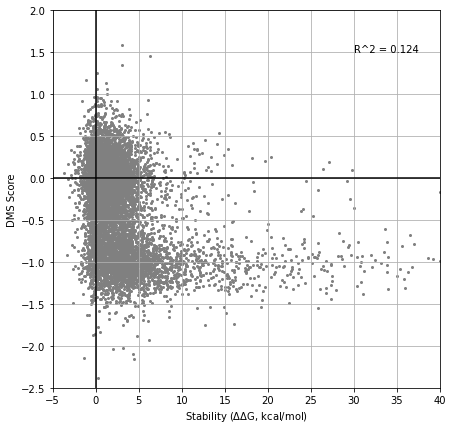

In [128]:
correlateDMSscoreStability ( di_m, di_s, score_m, score_s, 1.5, -5, 40, -2.5, 2.0, 'Stability ($\Delta\Delta$G, kcal/mol)', 'DMS Score')


In [143]:
def file2dict ( file ):
    '''
    '''
    with open( file, 'r') as f:
        o = f.read()
        f.close()
    t = o.split('\n')

    d = {}
    for i in range(len(t)):
        if t[i]:
            d[t[i].split()[0]+t[i].split()[1]+t[i].split()[2]] = t[i].split()[3:]
    return d

### Map id to dimer stability

In [144]:
# cut -f2-4,9-12,27-28  all.summary | awk '{if($6>5.0 && $8){print }}'  | sort -n -k4 > id_dimerStability_DMSscore.txt
dimer_stability = file2dict ('../SUMMARY_DATA/id_dimerStability_DMSscore.txt')

In [150]:
compromisedResidues(list(dimer_stability.keys()))

10	K --> (3) FPW
11	F --> (1) P
16	I --> (1) P
17	L --> (3) HYP
23	L --> (1) P
24	L --> (1) P
25	L --> (1) P
35	F --> (1) T
36	V --> (1) P
38	C --> (5) PHFYW
40	Y --> (4) TGSP
41	V --> (9) DQEPHKWRY
42	I --> (1) P
43	I --> (1) P
44	L --> (3) GDP
45	M --> (5) DPWYH
47	I --> (1) P
48	Y --> (4) TGDP
49	W --> (3) EDP
52	E --> (1) P
53	V --> (2) HY
54	I --> (4) HFWY
57	A --> (3) RKW
58	V --> (3) HYW
59	T --> (5) HRYFW
60	S --> (13) INDLPMRQEKHFY
61	L --> (1) P
62	M --> (1) P
63	P --> (8) EDKYHFRW
64	V --> (6) PRKHYW
65	L --> (1) P
66	L --> (1) P
67	F --> (4) EGTP
68	P --> (13) INQLEDMKRHFYW
69	L --> (1) P
70	F --> (2) IP
71	Q --> (2) PF
72	I --> (9) DEKHPRFWY
73	L --> (2) HP
75	S --> (3) HFY
78	V --> (7) EQKRHYW
79	C --> (5) PHFYW
81	Q --> (3) FPW
82	Y --> (2) DP
83	M --> (1) P
86	T --> (3) HWY
87	N --> (5) HRYFW
88	M --> (2) YP
89	L --> (7) SGEDHPW
90	F --> (1) P
91	L --> (1) P
92	G --> (12) NMDIQLEKFRHY
93	G --> (1) Y
95	I --> (1) P
97	A --> (3) YHW
98	V --> (4) PHWY
99	A --> (6) KRHFYW
1

### Map id to VEPs

In [151]:
# cut -f2-4,33,35  all.summary  > id_ESM_AlphaMissense.txt
vep = file2dict ('../SUMMARY_DATA/id_ESM_AlphaMissense.txt')

In [153]:
compromisedResidues (list(vep.keys()))

1	M --> (19) ACDEFGHIKLNPQRSTVWY
2	A --> (19) CDEFGHIKLMNPQRSTVWY
3	S --> (19) ACDEFGHIKLMNPQRTVWY
4	A --> (19) CDEFGHIKLMNPQRSTVWY
5	L --> (19) ACDEFGHIKMNPQRSTVWY
6	S --> (19) ACDEFGHIKLMNPQRTVWY
7	Y --> (19) ACDEFGHIKLMNPQRSTVW
8	V --> (19) ACDEFGHIKLMNPQRSTWY
9	S --> (19) ACDEFGHIKLMNPQRTVWY
10	K --> (19) ACDEFGHILMNPQRSTVWY
11	F --> (19) ACDEGHIKLMNPQRSTVWY
12	K --> (19) ACDEFGHILMNPQRSTVWY
13	S --> (19) ACDEFGHIKLMNPQRTVWY
14	F --> (19) ACDEGHIKLMNPQRSTVWY
15	V --> (19) ACDEFGHIKLMNPQRSTWY
16	I --> (19) ACDEFGHKLMNPQRSTVWY
17	L --> (19) ACDEFGHIKMNPQRSTVWY
18	F --> (19) ACDEGHIKLMNPQRSTVWY
19	V --> (19) ACDEFGHIKLMNPQRSTWY
20	T --> (19) ACDEFGHIKLMNPQRSVWY
21	P --> (19) ACDEFGHIKLMNQRSTVWY
22	L --> (19) ACDEFGHIKMNPQRSTVWY
23	L --> (19) ACDEFGHIKMNPQRSTVWY
24	L --> (19) ACDEFGHIKMNPQRSTVWY
25	L --> (19) ACDEFGHIKMNPQRSTVWY
26	P --> (19) ACDEFGHIKLMNQRSTVWY
27	L --> (19) ACDEFGHIKMNPQRSTVWY
28	V --> (19) ACDEFGHIKLMNPQRSTWY
29	I --> (19) ACDEFGHKLMNPQRSTVWY
30	L --> (19) ACDEFGHIK